In [6]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [7]:
from path_overlap import * 

In [206]:
num_dense, num_sparse = 5, 5
tot_units = num_dense + num_sparse
density = .2
num_layers = 7
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [207]:
pos = nx.multipartite_layout(MPG)

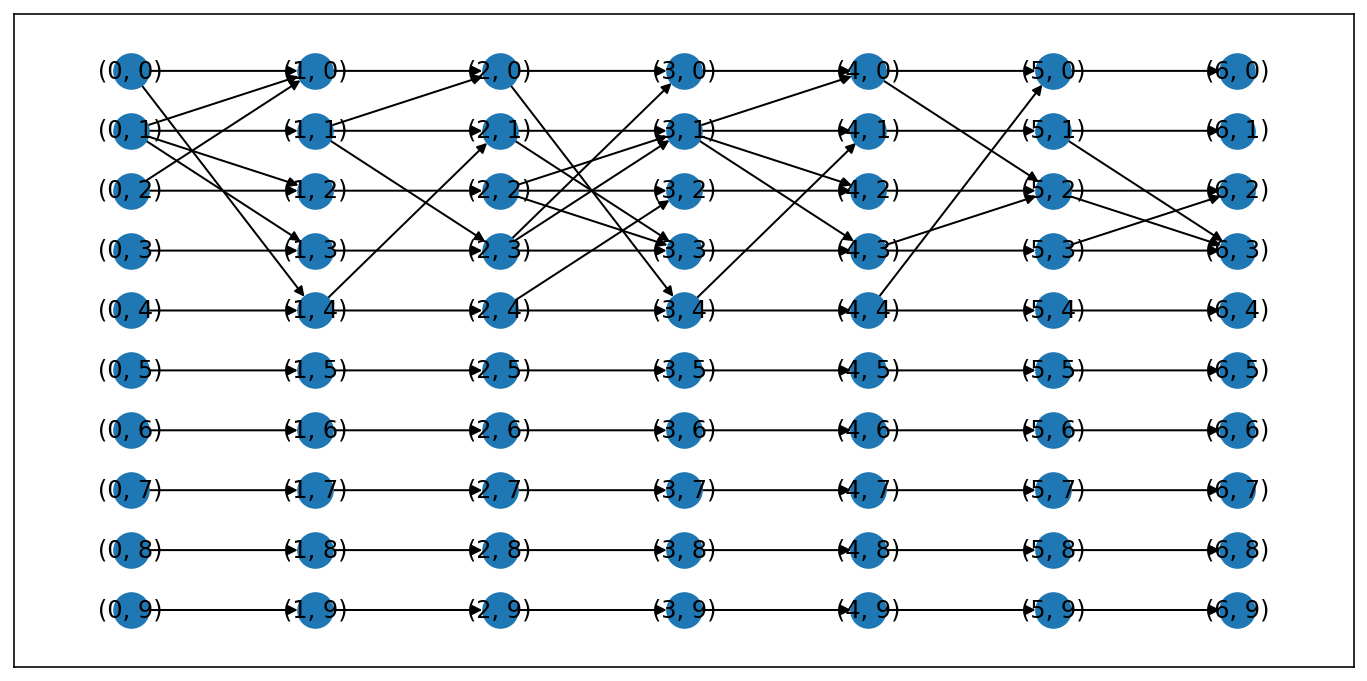

In [208]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [215]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=20)

In [216]:
rew_pos = nx.multipartite_layout(rew_MPG)

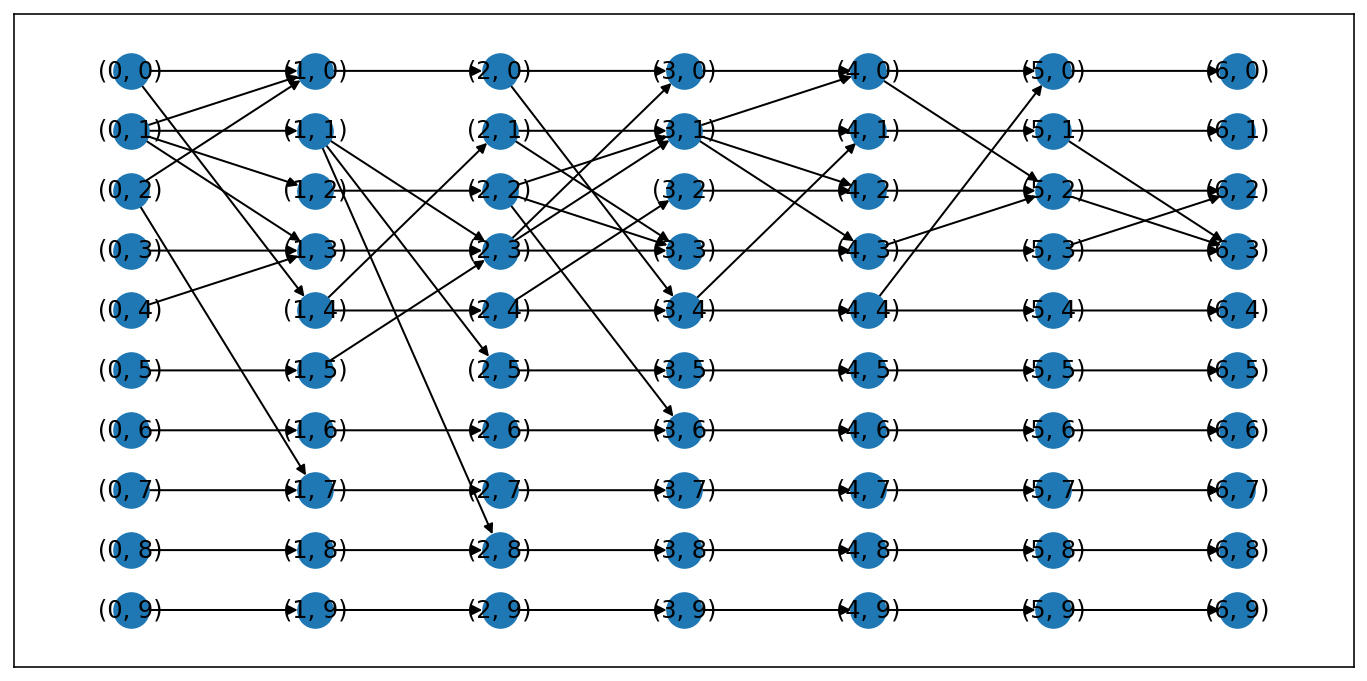

In [217]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [218]:
from itertools import combinations, product
output_nodes = [(num_layers-1, x) for x in range(tot_units)]
input_nodes = [(0, x) for x in range(tot_units)]

paths = {}
for n, nn in product(input_nodes, output_nodes):
    paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
rew_paths = {}
for n, nn in product(input_nodes, output_nodes):
    rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

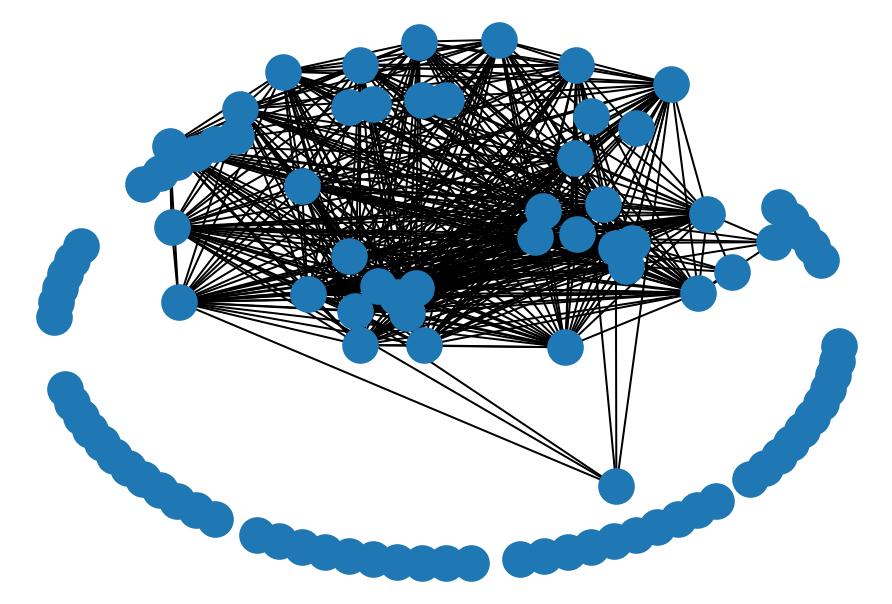

In [219]:
rew_IG = MP_interference_graph(rew_MPG, paths=rew_paths);
nx.draw_kamada_kawai(rew_IG)

In [220]:
def interference_complex(graph, paths, max_simplex_dimension):
    SC = {};
    SC[1] = {}
    for n in paths:
        SC[1][n] = 0;
    for k in range(2, max_simplex_dimension+2):
        SC[k] = {}
        for simplex in combinations(paths, k):
            path_families = [paths[s] for s in simplex]
            w = HO_interference(path_families, graph);
            if w!=None and w>0:
                SC[k][simplex] = w;
    return SC;

In [221]:
relabel_dict = dict(zip(list(paths.keys()), range(len(paths.keys()))))

In [222]:
rew_SC = interference_complex(rew_MPG, rew_paths, 2)

In [223]:
def relabel_SC(sc, rl_dict):
    rl_sc = {};
    for d in sc:
        rl_sc[d] = {}
        if d==1:
            for simp in sc[d]:
                new_simp = frozenset([rl_dict[simp]]);
                rl_sc[d][new_simp] = sc[d][simp];
        else:
            for simp in sc[d]:
                new_simp = frozenset([rl_dict[x] for x in simp]);
                rl_sc[d][new_simp] = sc[d][simp];
    return rl_sc;

In [224]:
rl_SC = relabel_SC(rew_SC, relabel_dict)

In [240]:
def preliminary_interference_SC_filtration(sc):
    fil = [];
    for d in sc:
        for simp in sc[d]:
            fil.append((list(simp), sc[d][simp]))
    return fil;

def interference_filtration_closure(fil, sc, epsilon=0.001):
    filled_fil = fil.copy();
    dims = sorted(list(sc.keys()));
    for d in dims[::-1]:
        if d==1:
            continue;
        for simp in sc[d]:
            for subface in combinations(simp, d-1):
                if subface not in sc[d-1]:
                    filled_fil.append([list(subface), sc[d][simp] -  epsilon])
    return filled_fil;

<BarContainer object of 3 artists>

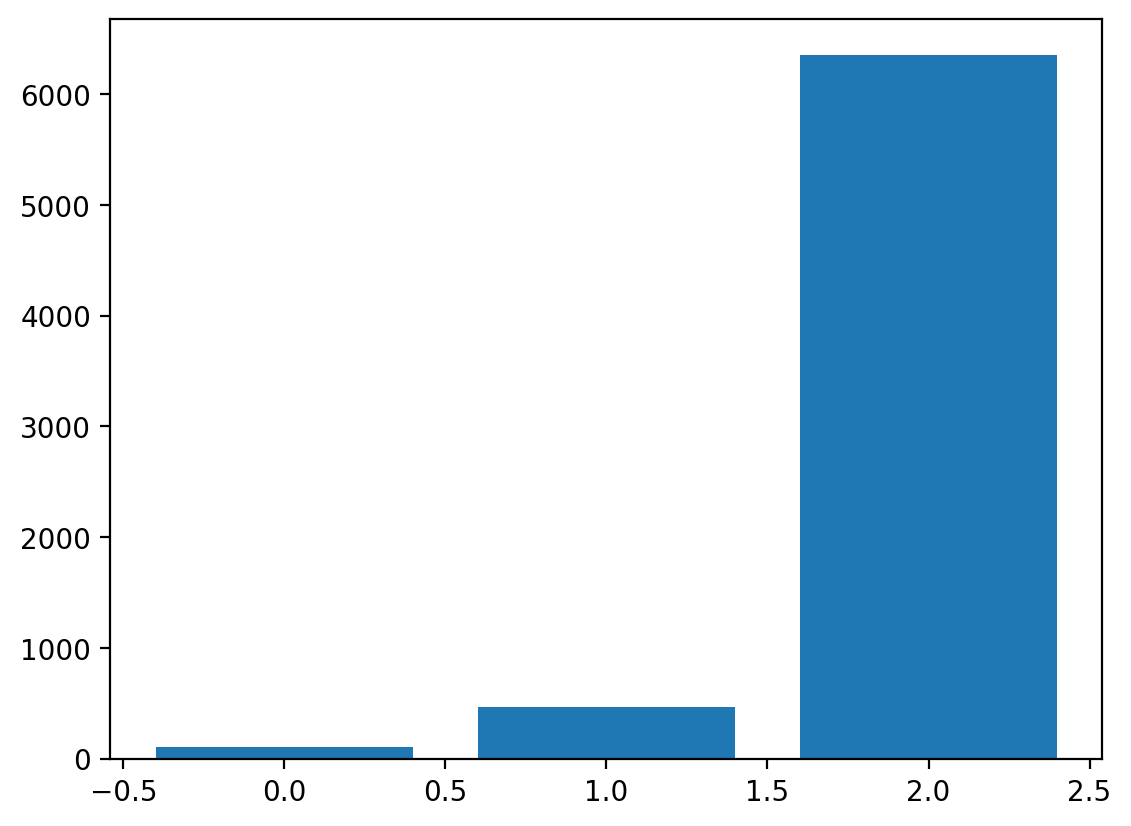

In [246]:
plt.bar([0,1,2], list(map(len, rl_SC.values())))


In [259]:
# from seaborn import displot
# fig = plt.figure()
# ax = plt.gca()
# for d in [1,2,3]:
#     displot(rl_SC[d].values(), bins = np.linspace(0,1,10), label=d)
# plt.legend()
    

In [241]:
rl_fil = interference_SC_filtration(rl_SC)
rl_filled_fil = interference_filtration_closure(rl_fil, rl_SC)

In [242]:
#Compute persistence diagrams
import cechmate as cm
dgms = cm.phat_diagrams(rl_filled_fil, show_inf = True)
print("H0:\n", dgms[0])
print("H1:\n", dgms[1])

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.346)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.0591)
H0:
 [[0.         0.07042857]
 [0.         0.07042857]
 [0.         0.07042857]
 ...
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]]
H1:
 [[0.07042857 0.07142857]
 [0.07042857 0.07142857]
 [0.07042857 0.07142857]
 ...
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]]


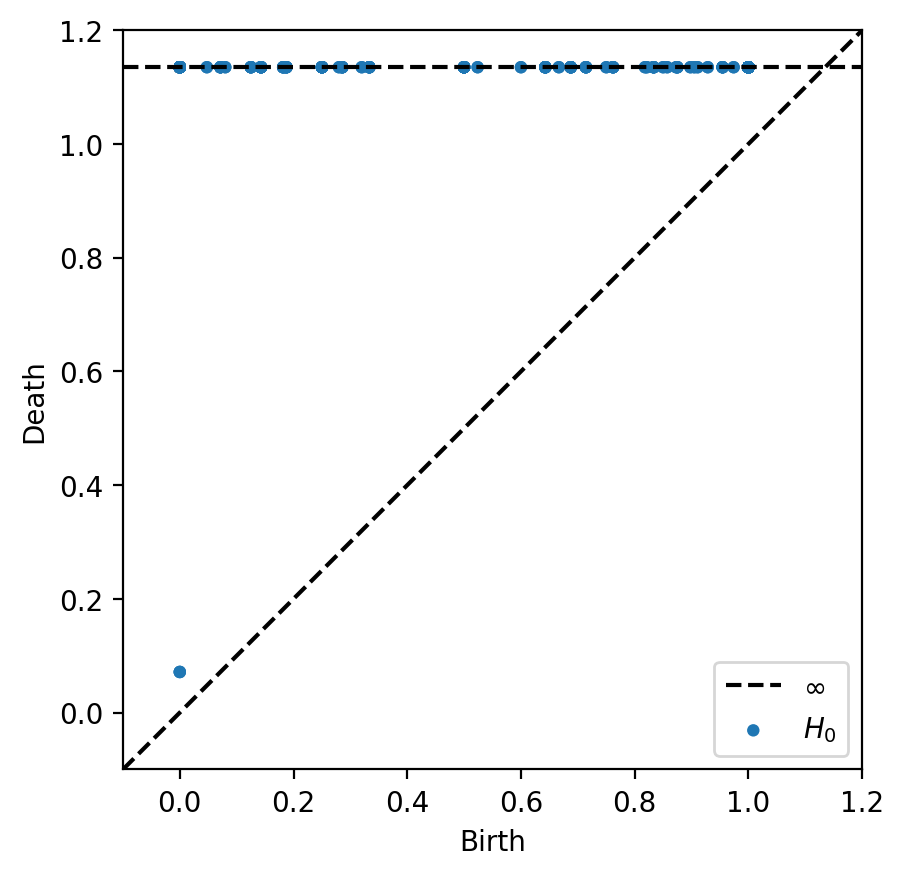

In [239]:
from persim import plot_diagrams
plot_diagrams(dgms[0])